In [1]:
from loadParameters import *
from defaultFunctions import *
from pypetFunctions import *
%matplotlib inline


In [9]:

def kuramoto_new(xs_osz, gausssigma=0, plot=False):
    '''
    IMPORTANT: THIS FUNCTION DISCARDS FIRST 1000 STEPS IN KUR !!!!!!!!!!!
    '''
    plotData = []
    phase = []
    maxima = []
    xs_osz = xs_osz[:,9000:20000]
    N, T = xs_osz.shape
    for n in range(N):
        plotData.append(xs_osz[n])
        if gausssigma==0:
            a = plotData[n]
        else:
            a = gaussian_filter1d(plotData[n], gausssigma) 
        maxima.append(np.r_[True, a[1:] > a[:-1]] & np.r_[a[:-1] > a[1:], True]) # find local maxima
        lastInterval = 2.0
        lastSpike = 1
        phase.append([])
        for i in range(T):
            if maxima[n][i] == True:
                lastInterval = i - lastSpike
                lastSpike = i
            phi = 2 * np.pi * float(i - lastSpike) / float(lastInterval+1e-9)
            phase[n].append(phi)
    phases = np.asarray(phase)
    rad = np.exp(1.j * phases)
    K = 1/float(rad.shape[0]) * np.abs( np.sum(rad,axis=0))
    kur_mean = np.mean(K[1000:])
    kur_std = np.std(K[1000:])
    if plot == True:
        plt.figure(figsize=(8, 2), dpi=150)
        plt.plot(K[1000:-100])
        plt.xlabel('Timesteps [dt]')
        plt.ylabel(r'$\dfrac{1}{N}\sum^N_{j=1} e^{i\theta_j}$')
        plt.title(r'Kuramoto Index: $z = ({} \pm {}), {}$  nodes)'.format(np.round(kur_mean, 4), np.round(kur_std, 4),phases.shape[0]))
        plt.show()
    return kur_mean, kur_std


def load_parameters_params4_HCP10(nodes=90):
    '''
    Modification to default parameter set
    For now, priority is sinusodial oscillation, modified so that dfreq more "realistic"
    + : sinusoidal oscillation
    + : u>0 for all I
    + : convenient parameter spaces
    - : "batman shaped" dominant frequency
    '''
    
    SCs90_HCP10 = np.load('HCP10/HCP10_SCs_aal90_EVnorm.npy')
    SC90 = np.mean(SCs90_HCP10,axis=0)
    DMs90_HCP10 = np.load('HCP10/HCP10_LENs_aal90_unnormed.npy')
    DM90 = np.mean(DMs90_HCP10,axis=0)
    SCs246_HCP10 = np.load('HCP10/HCP10_SCs_bn246_EVnorm.npy')
    SC246 = np.mean(SCs246_HCP10,axis=0)
    DMs246_HCP10 = np.load('HCP10/HCP10_LENs_bn246_unnormed.npy')
    DM246 = np.mean(DMs246_HCP10,axis=0)
    
    if nodes==1:
        params = load_parameters(singleNode=True, globalN=0)
    elif nodes==90:
        params = load_parameters()
        params['SC'] = SC90
        params['DM'] = DM90
    
    elif nodes==246:
        params = load_parameters()
        params['SC'] = SC246
        params['DM'] = DM246
        params['N']=246
        
    else:
        raise Exception('Unknown atlas!')
    params['alpha'] = 3.
    params['beta'] = 4
    params['gamma'] = -3./2
    params['tau'] = 20
    params['u_thres'] = 0.5 # given by bifurcation diagram, central value of LC
    params['rms_thres'] = 0.01 # so that even strong noise (sigma=1.) is still not considered oscillation

    params['duration'] = 3000
    params['dt'] = 0.1
    
    params['init'] = (0,1,0,1) # uniform range for u&w, (99,99,99,99)=at FP for single node
    params['I'] = 0.5 # (not too) close to bifurcation point
    params['K'] = 0.
    params['ou_sigma'] = 0.
    params['ou_tau'] = 2.
    
    #only for plotting the phase space...
    params['ups_min']=-.5; params['ups_max']=1.5;params['wps_min']=0.; params['wps_max']=2.5
    params['wps_step']=0.1; params['ups_step']=0.05
    return params
SCs90_HCP10 = np.load('HCP10/HCP10_SCs_aal90_EVnorm.npy')
SC90 = np.mean(SCs90_HCP10,axis=0)
DMs90_HCP10 = np.load('HCP10/HCP10_LENs_aal90_unnormed.npy')
DM90 = np.mean(DMs90_HCP10,axis=0)
SCs246_HCP10 = np.load('HCP10/HCP10_SCs_bn246_EVnorm.npy')
SC246 = np.mean(SCs246_HCP10,axis=0)
DMs246_HCP10 = np.load('HCP10/HCP10_LENs_bn246_unnormed.npy')
DM246 = np.mean(DMs246_HCP10,axis=0)


def mean_frms_amp(us, params, plothist=True):
    '''
    Calculate the mean potential u_mean, the dominant frequency f_dom, and the fluctuation amplitude u_amp
    for each node of a simulated time series us. 
    The parameter peakprom is a measure for the prominance of the dominant peak in the PDS
    '''
    means = np.mean(us, axis=1)
    n, l = us.shape
    fs = 1000/params['dt']
    amps = np.max(us[:,l//2:], axis=1)-np.min(us[:,l//2:], axis=1)
    dfreqs = np.zeros(n); frms = np.zeros(n)
    for n in range(n):
        freqs, Pxx_spec = welch(us[n], fs, 'flattop', nperseg=l, scaling='spectrum')
        frms[n] = np.sqrt(np.max(Pxx_spec))
        dfreqs[n] = freqs[np.argmax(Pxx_spec)]

    if plothist:
        ft = dfreqs.copy()
        ft[frms<params['rms_thres']] = 0
        ubins = np.linspace(np.min((np.min(amps),np.min(means))), np.max((np.max(amps), np.max(means))), 10)
        fig, ax = plt.subplots(figsize=(7,4), dpi=200)
        n_m, bins_m, _ = ax.hist(x=means, bins=ubins, color='red', alpha=0.5, rwidth=0.85, label=r'Mean $\bar{u}$')
        ax.grid(axis='y', alpha=0.75)
        ax.set_xlabel('u')
        ax.set_ylabel('Number of Nodes')
        ax.tick_params(axis='x')
        ax2 = ax.twiny()
        n_ft, bins_ft, _ = ax2.hist(x=ft, bins='auto', color='blue', histtype='bar', alpha=0.5, rwidth=0.85, label='Frequency (thres)')
        ax2.set_xlabel('Frequency [Hz]', color='blue')
        ax2.tick_params(axis='x', labelcolor='blue')
        n_a, bins_a, _ = ax.hist(x=amps, bins=ubins, color='green', alpha=0.3, rwidth=0.85, label=r'Amplitude $\Delta u$')
        fig.legend(loc=10)
        plt.show()
    return means,  frms, amps


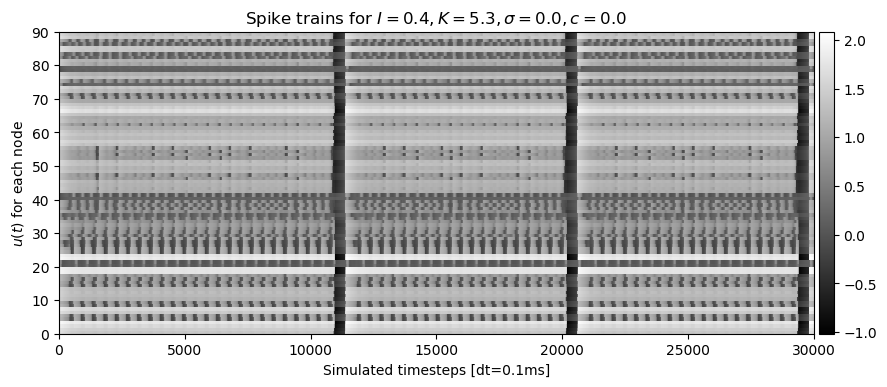

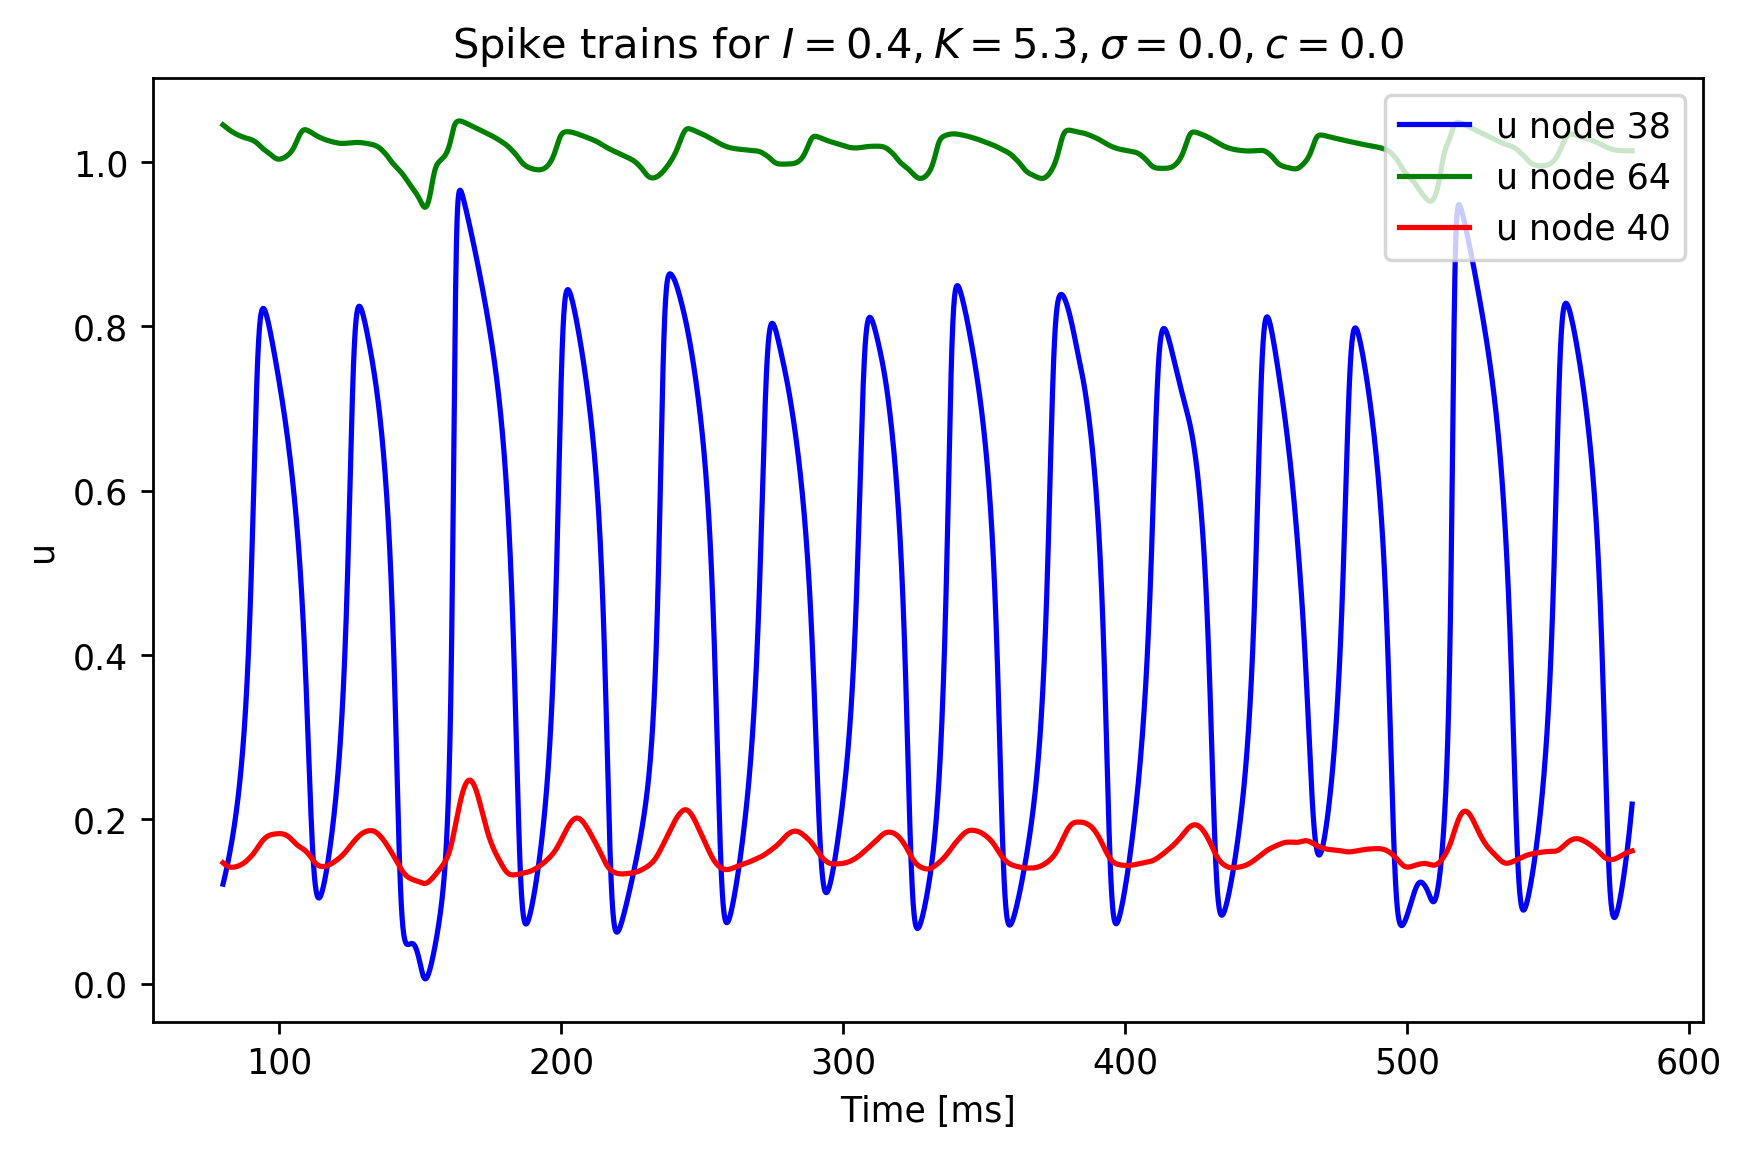

In [8]:
par=load_parameters_params4_HCP10()
par['I']=0.4
par['K']=5.3
par['c']=0.
par['sigma']=0.
par['rms_thres']=0.01
nodes = [38,64,40]

ts,xs,ys,_,_,_ = timeIntegrationRK4(par, randomseed=1)
plotSpikeTrain(xs[:,:],par)
#_,_,frms,_ = mean_freq_frms_amp(xs[:,-10000:],par,plothist=True)
#kuramoto_new(xs[frms>par['rms_thres']],plot=True)
plotSpikeTrainNodes(ts[800:], xs[:,800:], nodes, par,show_ms=500)
#plotSpecNodes(xs[:,-10000:],nodes,par)


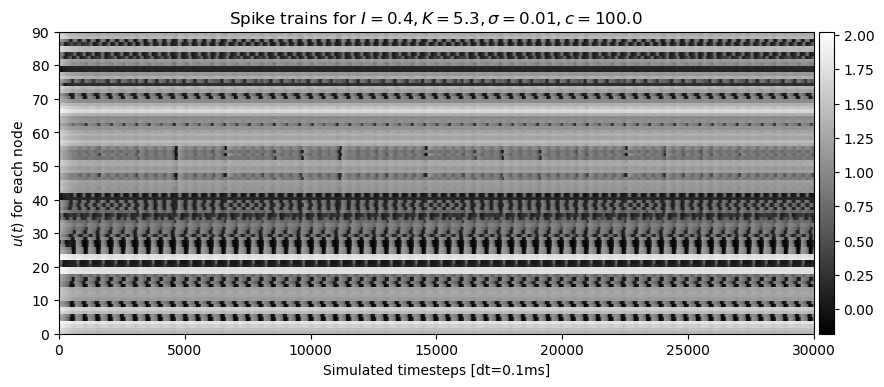

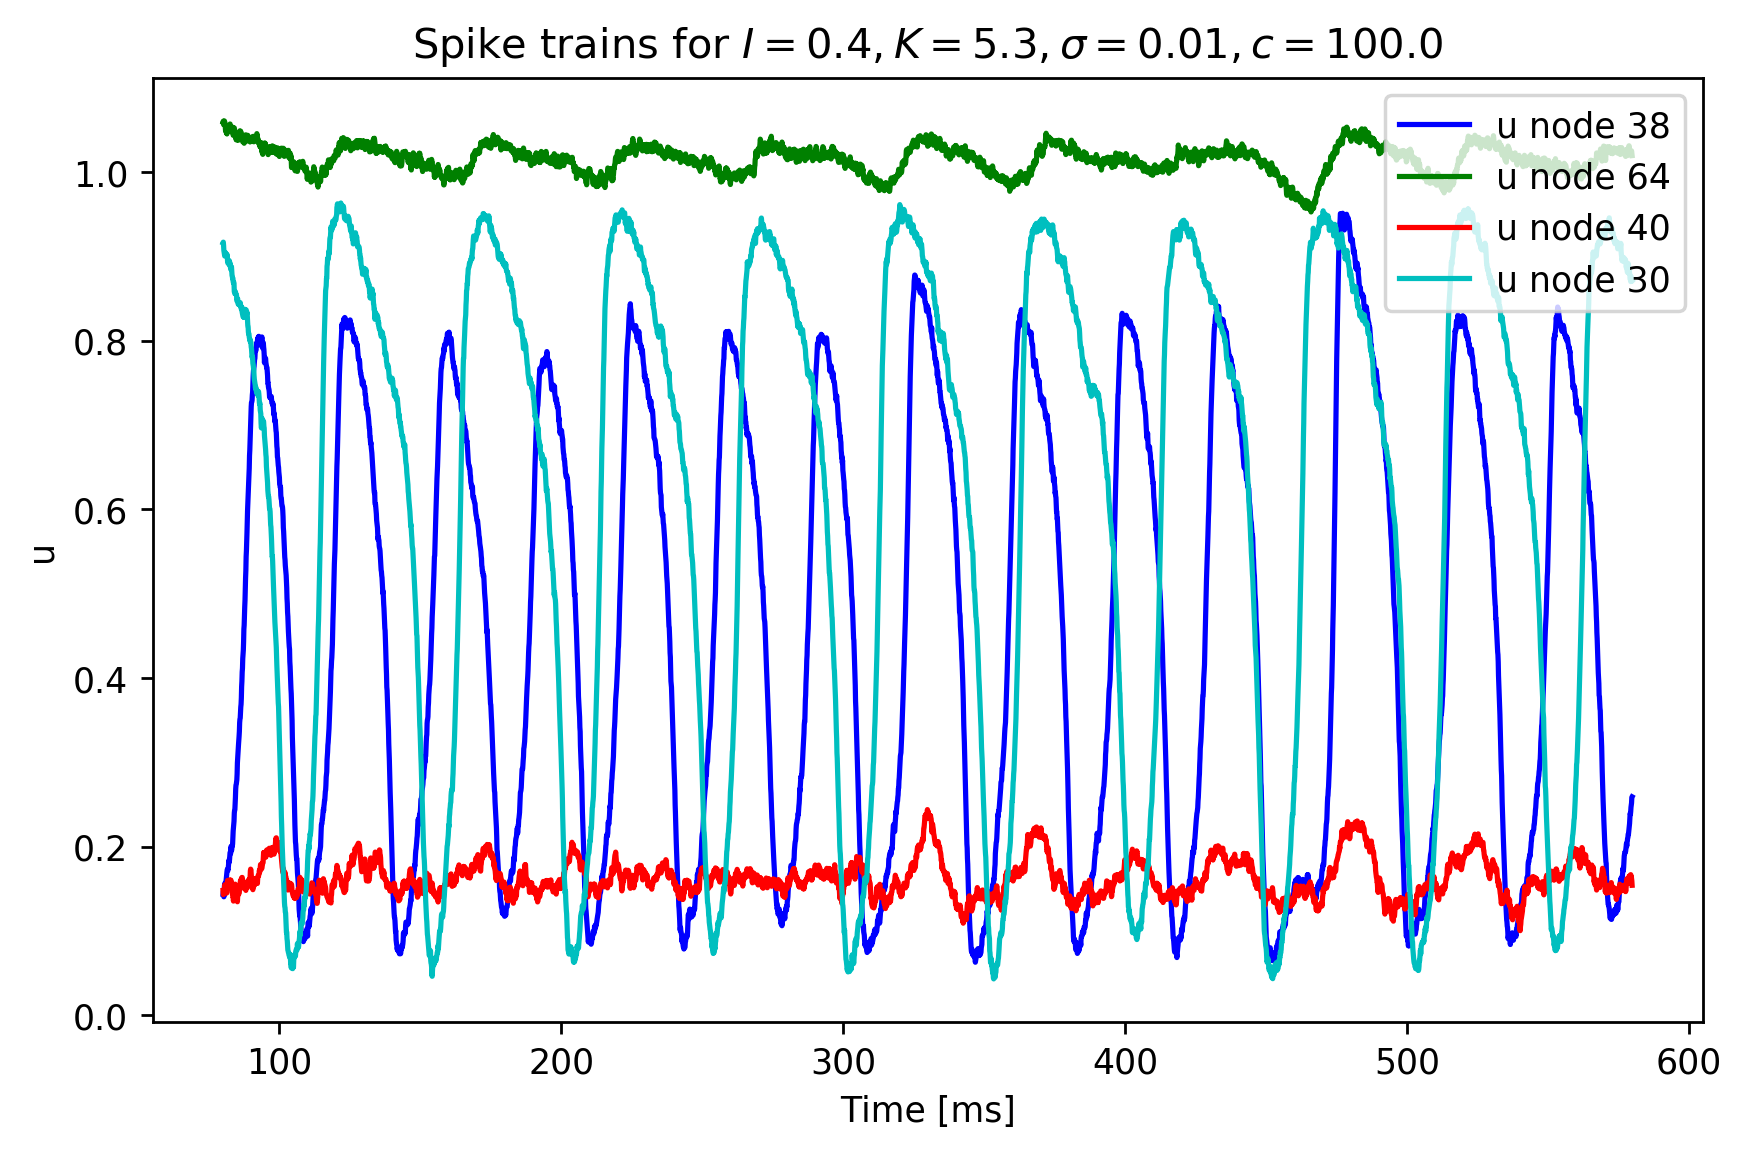

In [2]:
par=load_parameters_params4_HCP10()
par['I']=0.4
par['K']=5.3
par['c']=100.
par['sigma']=0.01
par['rms_thres']=0.01
nodes = [38,64,40, 30]

ts,xs,ys,_,_,_ = timeIntegrationRK4(par, randomseed=1)
plotSpikeTrain(xs[:,:],par)
#_,_,frms,_ = mean_freq_frms_amp(xs[:,-10000:],par,plothist=True)
#kuramoto_new(xs[frms>par['rms_thres']],plot=True)
plotSpikeTrainNodes(ts[800:], xs[:,800:], nodes, par,show_ms=500)
#plotSpecNodes(xs[:,-10000:],nodes,par)


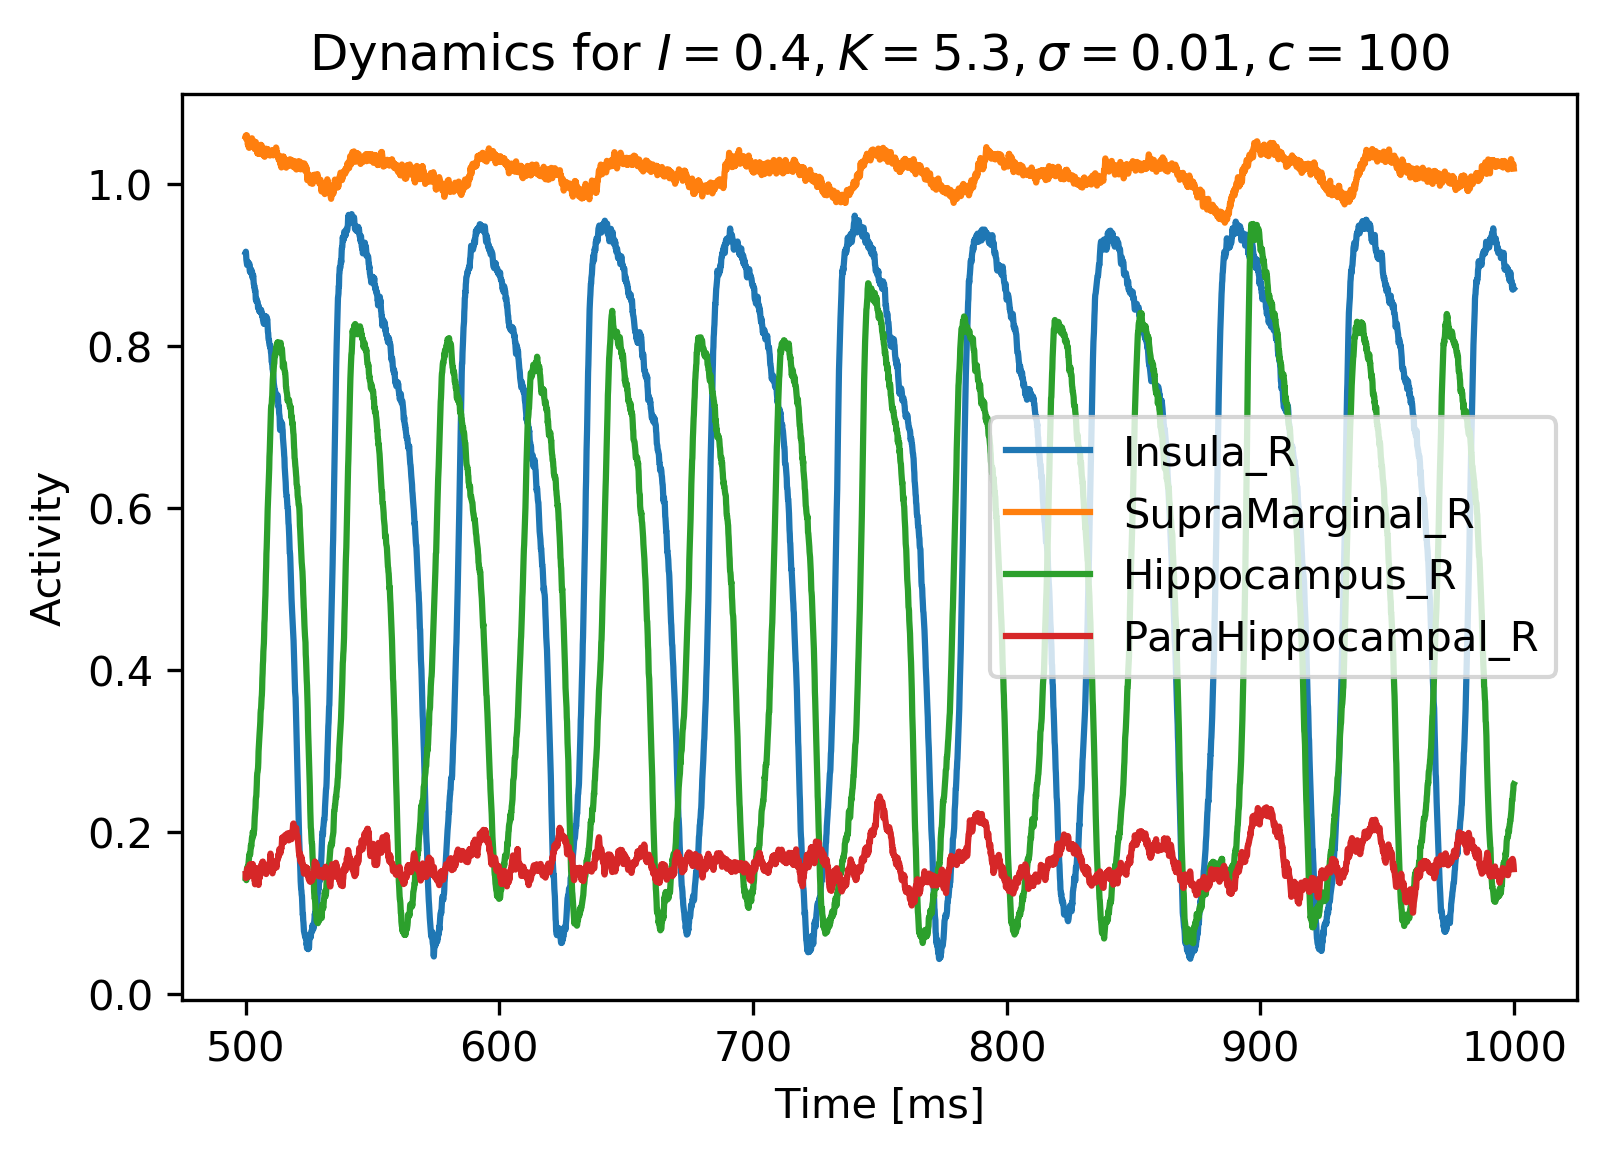

In [6]:
plt.figure(figsize=(6,4), dpi=300)
plt.plot(ts[5000:10000], xs[30,800:5800], label='Insula_R')
plt.plot(ts[5000:10000], xs[64,800:5800], label='SupraMarginal_R')
plt.plot(ts[5000:10000], xs[38,800:5800], label='Hippocampus_R')
plt.plot(ts[5000:10000], xs[40,800:5800], label='ParaHippocampal_R')
plt.legend()
plt.xlabel('Time [ms]')
plt.ylabel('Activity')
plt.title(r'Dynamics for $I = 0.4, K = 5.3, \sigma = 0.01, c = 100$')
plt.show()

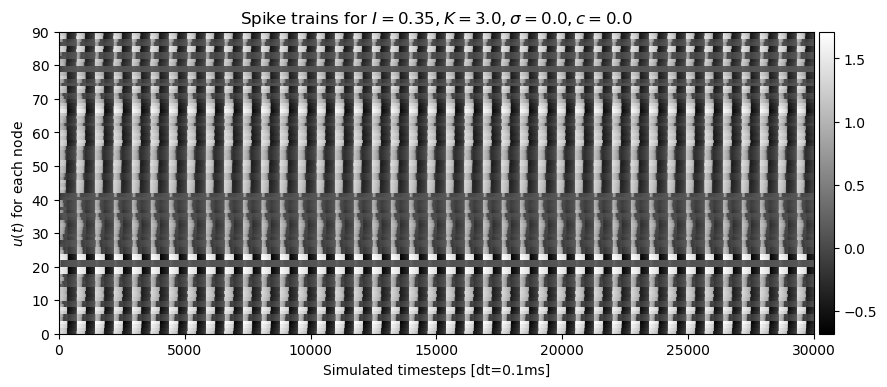

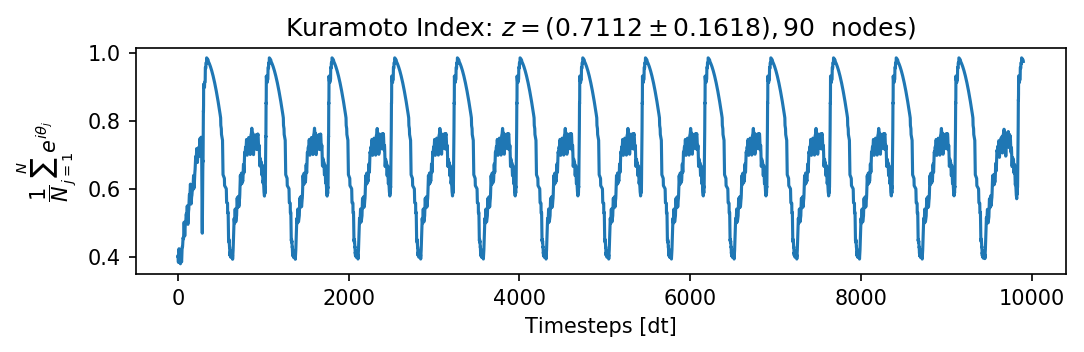

(0.7112017767240424, 0.16183418252803078)

In [10]:
par=load_parameters_params4_HCP10()
par['I']=0.35
par['K']=3.
par['c']=0.
par['sigma']=0.
nodes = [22,64,40]

ts,xs,ys,_,_,_ = timeIntegrationRK4(par, randomseed=1)
plotSpikeTrain(xs[:,:],par)
_,frms,_=mean_frms_amp(xs,par,plothist=False)
kuramoto_new(xs[frms>0.01],plot=True)

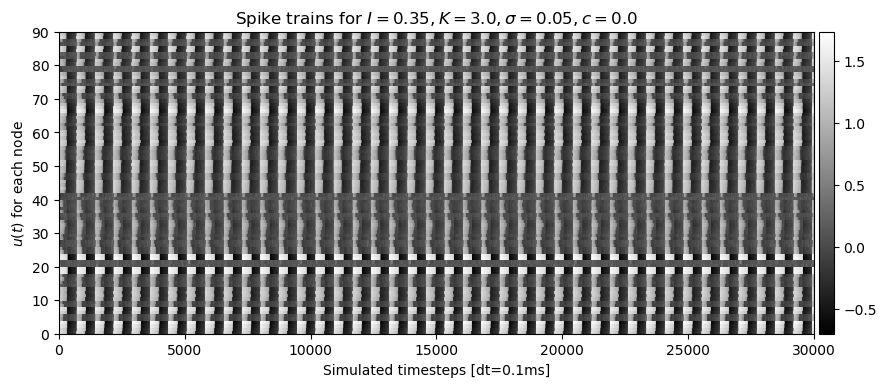

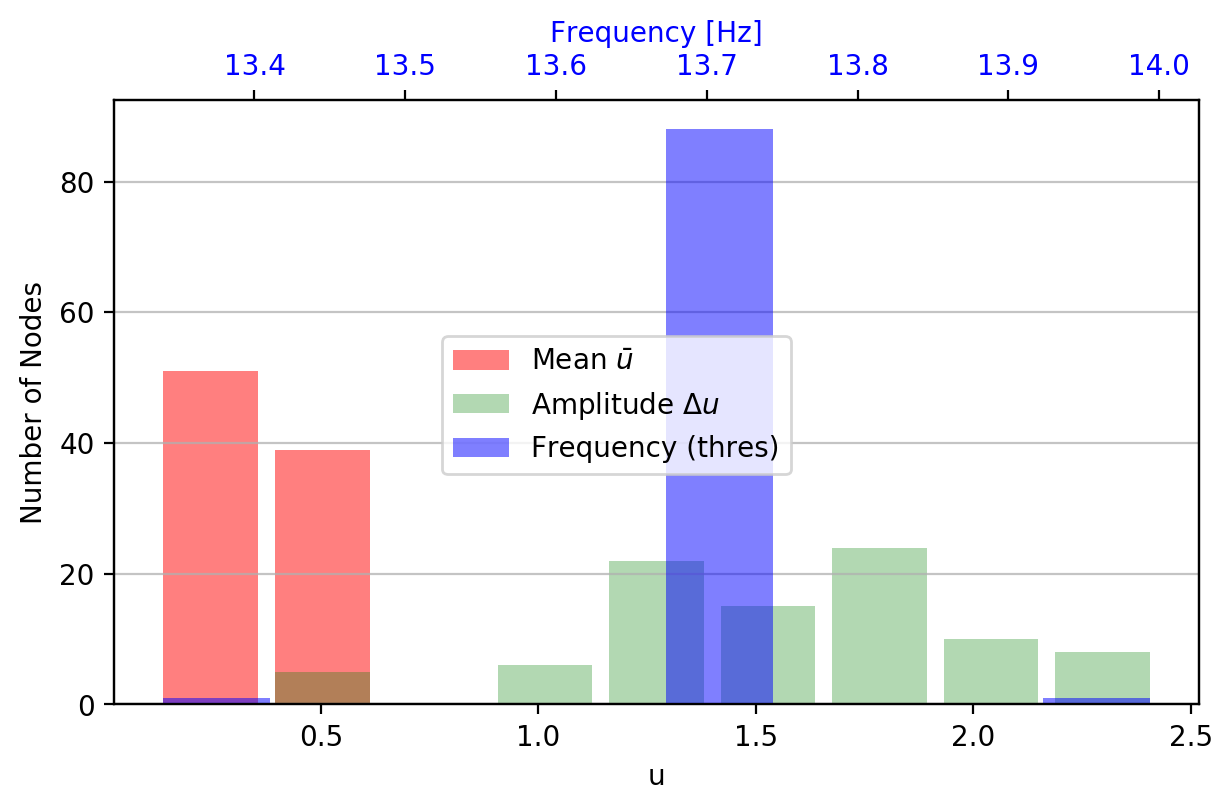

In [3]:
par=load_parameters_params4_HCP10()
par['I']=0.35
par['K']=3.
par['c']=0.
par['sigma']=0.05
nodes = [22,64,40]

ts,xs,ys,_,_,_ = timeIntegrationRK4(par, randomseed=1)
plotSpikeTrain(xs[:,:],par)
_,frms,_=mean_frms_amp(xs,par,plothist=True)
#kuramoto_new(xs[frms>0.01],plot=True, gausssigma=200.)